# 实验题目：2023年股票数据的爬取和挖掘

## 实验目标：围绕A股市场进行分析

- 以 **A 股** 作为背景，选取热门行业，以 **2018 年至今** 为时间范围，对 **东方财富网** 的股票数据进行爬取和整理；
- 模仿股票网站的 k 线，做出 **箱线图和折线图**，让技术人员更清晰、更准确的分析行业的走势；
- **分析 2018 年与 2022 年的行业数据**，了解行业的发展情况，并结合国内外实际情况对股票的影响，为投资者提供帮助；
- 做出 **聚类模型**，根据股票的 **涨跌幅和振幅** 等特征数据，将不同的股票划分为不同的簇，以帮助投资者更好地理解不同类型的股票。

## 实验内容

### 1. 数据爬取

爬虫爬取 [东方财富网](https://www.eastmoney.com/) 上的数据（股票及行业数据）。
注意：爬取股票日 k 的数据，行业周 k 的数据，方便后面做可视化分析以及建模。

#### 1.1. 爬取股票日 k 的数据

In [4]:
import requests
from datetime import datetime
import pandas as pd
import os
from pprint import pprint


def fetch_stock_daily_k_data(
        stock_code, 
        stock_exchange='0',
        start_date='2018-01-01', 
        end_date=None, 
        fq=1, 
        other_info=None,
        folder_name='kline_data'):
    """
    获取指定股票代码的历史K线数据。
    :param stock_code: 股票代码，如'000001'（平安银行）
    :param stock_exchange: 股票交易所，0为沪市，1为深市，默认为0
    :param start_date: 开始日期，字符串格式，默认为'2018-01-01'
    :param end_date: 结束日期，字符串格式，默认为当前日期
    :param fq: 复权类型，1为前复权，2为后复权，默认为1
    :param other_info: 其他信息，行业、地域、概念，如提供则会保存到Excel文件中
    :param folder_name: 保存数据的文件夹名称，默认为'kline_data'
    :return: 包含历史K线数据的DataFrame
    """
    start_date = datetime.strptime(start_date, "%Y-%m-%d").strftime("%Y%m%d")
    if end_date is None:  # 如果未指定结束日期，则默认为今天
        end_date = datetime.now().strftime('%Y%m%d')
    print(f"Fetching data from {start_date} to {end_date} for stock {stock_code}...")
    
    # 所需字段
    columns = [
        '股票代码', '股票名称', '日期', '开盘价', '收盘价', '最高价', '最低价',
        '成交量', '成交额', '振幅(%)', '涨跌幅(%)', '涨跌额', '换手率(%)',
    ]
    if other_info is not None:
        columns += ['行业', '地域', '概念', ]

    # 请求API获取部分数据
    base_url = "https://push2his.eastmoney.com/api/qt/stock/kline/get?"
    # secid字段：0.代表沪市，1.代表深市；.后面跟随股票代码
    secid_fields1 = f"secid={stock_exchange}.{stock_code}&fields1=f1,f2,f3,f4,f5,f6&"
    # fields2字段：f51: 日期；f52: 开盘价；f53: 收盘价；f54: 最高价；f55: 最低价；
    #   f56: 成交量；f57: 成交额；f58: 振幅；f59: 涨跌幅；f60: 涨跌额；f61: 换手率；
    fields2 = "fields2=f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61&"
    # klt字段：101代表日K线，102代表周K线，103代表月K线；fqt字段：1代表前复权，2代表后复权；beg和end字段：开始和结束日期
    klt_fqt_beg_end = f"klt=101&fqt={fq}&beg={start_date}&end={end_date}"
    url_api = base_url + secid_fields1 + fields2 + klt_fqt_beg_end
    response = requests.get(url_api)
    response.raise_for_status()
    data = response.json()
    # pprint(data)
    
    # 从API返回的数据中提取部分所需字段
    try:
        klines_data = data['data']['klines']
    except Exception as e:
        print(f"Error: {e}\nPlease check stock exchange or any other parameters.")
        return None
    stock_name = data['data']['name'].replace('*', '')  # 要去掉股票名中的星号
    klines_table = []
    for kline in klines_data:
        kline = kline.split(',')
        kline = [stock_code, stock_name] + kline
        if other_info is not None:
            kline += other_info
        klines_table.append(kline)
    # print(klines_table[:5])
    klines_table = pd.DataFrame(klines_table, columns=columns)

    # 保存数据到excel文件
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    try:
        klines_table.to_excel(f"{folder_name}/{stock_code}_{stock_name}_daily_k_data.xlsx", index=False)
        print(f"Data saved to {folder_name}/{stock_code}_{stock_name}_daily_k_data.xlsx successfully.\n")  
    except Exception as e:
        print(f"Error: {e}\nPlease check if the file is open and close it before running the script again.")
    return klines_table


fetch_stock_daily_k_data('300496', stock_exchange='0')

Fetching data from 20180101 to 20240529 for stock 300496...
Data saved to kline_data/300496_中科创达_daily_k_data.xlsx successfully.



,股票代码,股票名称,日期,开盘价,收盘价,最高价,最低价,成交量,成交额,振幅(%),涨跌幅(%),涨跌额,换手率(%)
0,300496,中科创达,2018-01-02,31.09,31.49,31.67,30.76,63443,207948497.00,2.94,1.88,0.58,2.84
1,300496,中科创达,2018-01-03,31.54,32.05,32.19,31.09,71643,237061133.00,3.49,1.78,0.56,3.21
2,300496,中科创达,2018-01-04,32.09,31.73,32.21,31.72,53441,178076602.00,1.53,-1.00,-0.32,2.40
3,300496,中科创达,2018-01-05,31.70,31.29,32.19,31.24,51952,172179630.00,2.99,-1.39,-0.44,2.33
4,300496,中科创达,2018-01-08,32.27,31.71,32.87,31.30,79044,263863369.00,5.02,1.34,0.42,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,300496,中科创达,2024-05-23,53.05,50.70,54.42,50.56,391800,2037515079.00,7.58,-0.47,-0.24,10.68
1549,300496,中科创达,2024-05-24,51.00,49.25,53.10,49.09,324576,1660948663.00,7.91,-2.86,-1.45,8.84
1550,300496,中科创达,2024-05-27,49.43,50.15,50.59,48.50,249520,1240794084.00,4.24,1.83,0.90,6.80
1551,300496,中科创达,2024-05-28,50.01,48.38,50.01,48.28,178930,876287707.00,3.45,-3.53,-1.77,4.87


#### 1.2. 爬取指定行业（概念、板块）中所有股票日 k 数据

行业、概念、地域板块的代码均是BK+四位数字，因此这三类板块均可通过相同的方式获取。

In [5]:
def fetch_category_stocks(category, crawl_all=False):
    """
    获取指定行业/概念/地域板块内所有股票的代码。
    :param category: 行业/概念/地域板块代码，如'0447'（互联网服务）、'0918'（特高压）
    :param crawl_all: 是否爬取所有股票的数据，默认为False
    :return: 行业/概念/地域板块内所有股票的代码列表
    """
    # pn: 页码；pz: 每页数量；po: 排序方式(0: 正序，1: 倒序)；fid: 排序字段
    base_url = "http://push2.eastmoney.com/api/qt/clist/get?pn=1&pz=1000&po=0&np=1&fltt=2&invt=2&fid=f12&"
    # fs: 股票筛选条件；bk: 板块代码
    fs = f"fs=b:BK{category}&"
    # fields: 返回字段；f12: 股票代码；f13: 交易所，0为深证，1为上证；f14: 股票名称；f100: 行业；f102: 地域；f103: 概念
    fields = "fields=f12,f13,f14,f100,f102,f103"
    url = base_url + fs + fields
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    # pprint(data)
    
    stocks = data['data']['diff']
    stocks_all_info = [list(stock.values()) for stock in stocks]
    # 股票代码开头900、200为B股，5位为H股，需要排除
    stocks_all_info = [stock for stock in stocks_all_info if not stock[0].startswith(('900', '200')) and len(stock[0]) == 6]
    # print(stocks_all_info[0])
    stock_codes = [stock[0] for stock in stocks_all_info]  # 股票代码
    if not crawl_all:
        return stock_codes
    
    # 收集股票信息，爬取所有股票的数据
    stock_exchanges = [stock[1] for stock in stocks_all_info]  # 交易所
    stock_info = [[stock[3], stock[4], stock[5]] for stock in stocks_all_info]  # 行业、地域、概念
    len_stock_codes = len(stock_codes)
    for i in range(len_stock_codes):
        print(f"[{i+1}/{len_stock_codes}]", end=" ")
        fetch_stock_daily_k_data(
            stock_codes[i], stock_exchange=stock_exchanges[i], other_info=stock_info[i],
            folder_name=f"BK{category}_kline_data"
        )
    return stock_codes


Industry = "0447"  # 互联网服务
fetch_category_stocks(Industry, crawl_all=True)

[1/146] Fetching data from 20180101 to 20240529 for stock 000409...
Data saved to kline_data/000409_云鼎科技_daily_k_data.xlsx successfully.

[2/146] Fetching data from 20180101 to 20240529 for stock 000555...
Data saved to kline_data/000555_神州信息_daily_k_data.xlsx successfully.

[3/146] Fetching data from 20180101 to 20240529 for stock 000676...
Data saved to kline_data/000676_智度股份_daily_k_data.xlsx successfully.

[4/146] Fetching data from 20180101 to 20240529 for stock 000938...
Data saved to kline_data/000938_紫光股份_daily_k_data.xlsx successfully.

[5/146] Fetching data from 20180101 to 20240529 for stock 000997...
Data saved to kline_data/000997_新 大 陆_daily_k_data.xlsx successfully.

[6/146] Fetching data from 20180101 to 20240529 for stock 002095...
Data saved to kline_data/002095_生 意 宝_daily_k_data.xlsx successfully.

[7/146] Fetching data from 20180101 to 20240529 for stock 002115...
Data saved to kline_data/002115_三维通信_daily_k_data.xlsx successfully.

[8/146] Fetching data from 20180

['000409',
 '000555',
 '000676',
 '000938',
 '000997',
 '002095',
 '002115',
 '002131',
 '002195',
 '002232',
 '002264',
 '002291',
 '002315',
 '002316',
 '002331',
 '002354',
 '002368',
 '002373',
 '002380',
 '002401',
 '002474',
 '002530',
 '002609',
 '002642',
 '002649',
 '002657',
 '002766',
 '002771',
 '002777',
 '002912',
 '002990',
 '003005',
 '003010',
 '300017',
 '300020',
 '300044',
 '300059',
 '300078',
 '300079',
 '300096',
 '300150',
 '300166',
 '300167',
 '300168',
 '300170',
 '300212',
 '300226',
 '300231',
 '300245',
 '300248',
 '300250',
 '300264',
 '300269',
 '300271',
 '300277',
 '300287',
 '300288',
 '300290',
 '300295',
 '300300',
 '300324',
 '300383',
 '300399',
 '300418',
 '300419',
 '300440',
 '300442',
 '300448',
 '300496',
 '300508',
 '300518',
 '300523',
 '300532',
 '300541',
 '300592',
 '300609',
 '300634',
 '300645',
 '300674',
 '300678',
 '300682',
 '300687',
 '300738',
 '300766',
 '300785',
 '300792',
 '300846',
 '300872',
 '300895',
 '300941',
 '301001',

#### 1.3. 将股票日数据转换为年数据

In [19]:
def convert_daily_to_yearly(daily_kline_folder):
    """
    将日K线数据转换为年数据。
    :param daily_kline_folder: 存放日K线数据的文件夹路径
    :return: 包含年数据的DataFrame
    """
    # 返回数据的字段
    columns = [
        '股票代码', '股票名称', '年份', '开盘价', '收盘价', '最高价', '最低价',
        '成交量', '成交额', '振幅(%)', '涨跌幅(%)', '涨跌额', '换手率(%)',
        '行业', '地域', '概念', 
    ]
    # 为返回数据创建空DataFrame
    yearly_kline = pd.DataFrame(columns=columns)

    # 统计日K线数据文件夹中的所有表格
    file_list = []
    for file in os.listdir(daily_kline_folder):
        if file.endswith('daily_k_data.xlsx'):
            file_list.append(file)
    file_num = len(file_list)
    print(f"Found {file_num} daily kline data files.")

    # 对每个表格内的数据进行处理
    for num, file in enumerate(file_list):
        # 读取表格数据
        file_path = os.path.join(daily_kline_folder, file)
        print(f"\n[{num+1}/{file_num}] Converting {file_path} to yearly data...", end=" ")
        df = pd.read_excel(file_path, dtype={'股票代码': str})

        # 提取年份，有些股票的数据可能不是从2018年开始的
        df['年份'] = df['日期'].str[:4]
        years = df['年份'].unique()
        print(f"Years: {years}")

        for year in years:
            # 提取日K线数据中，指定年份里的所有数据
            df_year = df[df['年份'] == year]
            # 开盘价、收盘价：年初和年末的第一天和最后一天的数据
            open_price = df_year['开盘价'].values[0]
            close_price = df_year['收盘价'].values[-1]
            # 最高价、最低价：全年的最高和最低价
            max_price = df_year['最高价'].max()
            min_price = df_year['最低价'].min()
            # 成交量、成交额：全年的总和
            volume = df_year['成交量'].sum()
            amount = df_year['成交额'].sum()
            # 其他需要计算的数据
            amplitude = (max_price - min_price) / min_price * 100  # 振幅
            price_change = close_price - open_price  # 涨跌额
            price_limit = price_change / open_price * 100  # 涨跌幅
            yearly_data = [
                df_year['股票代码'].values[0],
                df_year['股票名称'].values[0],
                year,
                open_price, close_price, max_price, min_price,
                volume, amount, amplitude,
                price_limit, price_change,
                df_year['换手率(%)'].mean(),  # 换手率取平均值
                df_year['行业'].values[0],
                df_year['地域'].values[0],
                df_year['概念'].values[0],
            ]
            yearly_kline.loc[len(yearly_kline)] = yearly_data

    # 将结果保存到Excel文件
    yearly_kline.to_excel(f"{daily_kline_folder}/yearly_kline_data.xlsx", index=False)


convert_daily_to_yearly('kline_data')

Found 148 daily kline data files.

[1/148] Converting kline_data\000409_云鼎科技_daily_k_data.xlsx to yearly data... Years: ['2018' '2019' '2020' '2021' '2022' '2023' '2024']

[2/148] Converting kline_data\000555_神州信息_daily_k_data.xlsx to yearly data... Years: ['2018' '2019' '2020' '2021' '2022' '2023' '2024']

[3/148] Converting kline_data\000676_智度股份_daily_k_data.xlsx to yearly data... Years: ['2018' '2019' '2020' '2021' '2022' '2023' '2024']

[4/148] Converting kline_data\000938_紫光股份_daily_k_data.xlsx to yearly data... Years: ['2018' '2019' '2020' '2021' '2022' '2023' '2024']

[5/148] Converting kline_data\000997_新 大 陆_daily_k_data.xlsx to yearly data... Years: ['2018' '2019' '2020' '2021' '2022' '2023' '2024']

[6/148] Converting kline_data\002095_生 意 宝_daily_k_data.xlsx to yearly data... Years: ['2018' '2019' '2020' '2021' '2022' '2023' '2024']

[7/148] Converting kline_data\002115_三维通信_daily_k_data.xlsx to yearly data... Years: ['2018' '2019' '2020' '2021' '2022' '2023' '2024']

[8/1

#### 1.4. 爬取行业（概念、板块）周 k 的数据

In [26]:
def fetch_category_weekly_k_data(
        category_code, 
        start_date='2018-01-01', 
        end_date=None, 
        fq=1):
    """
    获取指定行业/概念/地域板块的周K线数据。
    :param category_code: 行业/概念/地域板块代码，如'0447'（互联网服务）、'0918'（特高压）
    :param start_date: 开始日期，字符串格式，默认为'2018-01-01'
    :param end_date: 结束日期，字符串格式，默认为当前日期
    :param fq: 复权类型，1为前复权，2为后复权，默认为1
    :return: 包含周K线数据的DataFrame
    """
    start_date = datetime.strptime(start_date, "%Y-%m-%d").strftime("%Y%m%d")
    if end_date is None:  # 如果未指定结束日期，则默认为今天
        end_date = datetime.now().strftime('%Y%m%d')
    print(f"Fetching data from {start_date} to {end_date} for category {category_code}...")
    
    # 所需字段
    columns = [
        '板块代码', '板块名称', '日期', '开盘价', '收盘价', '最高价', '最低价',
        '成交量', '成交额', '振幅(%)', '涨跌幅(%)', '涨跌额', '换手率(%)',
    ]

    # 请求API获取部分数据
    base_url = "https://push2his.eastmoney.com/api/qt/stock/kline/get?"
    # secid字段：90.代表板块，.后面跟随板块代码
    secid_fields1 = f"secid=90.BK{category_code}&fields1=f1,f2,f3,f4,f5,f6&"
    # fields2字段：f51: 日期；f52: 开盘价；f53: 收盘价；f54: 最高价；f55: 最低价；
    #   f56: 成交量；f57: 成交额；f58: 振幅；f59: 涨跌幅；f60: 涨跌额；f61: 换手率；
    fields2 = "fields2=f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61&"
    klt_fqt_beg_end = f"klt=102&fqt={fq}&beg={start_date}&end={end_date}"  # 周K，klt=102
    url_api = base_url + secid_fields1 + fields2 + klt_fqt_beg_end
    print(f"Fetching from URL: {url_api}")
    response = requests.get(url_api)
    response.raise_for_status()
    data = response.json()
    
    # 从API返回的数据中提取部分所需字段
    try:
        klines_data = data['data']['klines']
    except Exception as e:
        print(f"Error: {e}\nPlease check category code or any other parameters.")
        return None
    # print(klines_data)
    category_code = data['data']['code']
    category_name = data['data']['name']
    klines_table = []
    for kline in klines_data:
        kline = kline.split(',')
        kline = [category_code, category_name] + kline
        klines_table.append(kline)
    # print(klines_table[:5])
    klines_table = pd.DataFrame(klines_table, columns=columns)

    # 保存数据到excel文件
    try:
        klines_table.to_excel(f"{category_code}_{category_name}_weekly_k_data.xlsx", index=False)
        print(f"Data saved to {category_code}_{category_name}_weekly_k_data.xlsx successfully.\n")  
    except Exception as e:
        print(f"Error: {e}\nPlease check if the file is open and close it before running the script again.")
    return klines_table


fetch_category_weekly_k_data('1162')

Fetching data from 20180101 to 20240530 for category 1162...
Fetching from URL: https://push2his.eastmoney.com/api/qt/stock/kline/get?secid=90.BK1162&fields1=f1,f2,f3,f4,f5,f6&fields2=f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61&klt=102&fqt=1&beg=20180101&end=20240530
Data saved to BK1162_AI手机_weekly_k_data.xlsx successfully.



,板块代码,板块名称,日期,开盘价,收盘价,最高价,最低价,成交量,成交额,振幅(%),涨跌幅(%),涨跌额,换手率(%)
0,BK1162,AI手机,2024-03-08,1006.46,1026.21,1057.14,989.57,22580299,39223354577.00,6.76,2.62,26.21,9.00
1,BK1162,AI手机,2024-03-15,1005.23,1035.79,1050.31,994.73,21724345,38028901462.00,5.42,0.93,9.58,8.65
2,BK1162,AI手机,2024-03-22,1046.58,1085.74,1112.90,1045.98,27846004,52877553615.00,6.46,4.82,49.95,11.09
3,BK1162,AI手机,2024-03-29,1086.11,1056.22,1089.35,981.39,36414458,67451736272.00,9.94,-2.72,-29.52,14.51
4,BK1162,AI手机,2024-04-03,1057.77,1055.13,1072.05,1034.21,22429921,40663972885.00,3.58,-0.10,-1.09,8.94
5,BK1162,AI手机,2024-04-12,1051.57,980.78,1051.57,979.60,30369483,51358808180.00,6.82,-7.05,-74.35,12.10
6,BK1162,AI手机,2024-04-19,974.91,924.95,984.69,891.01,31772664,62926176724.00,9.55,-5.69,-55.83,12.66
7,BK1162,AI手机,2024-04-26,907.94,974.76,979.33,887.26,22782198,50398474287.00,9.95,5.39,49.81,9.08
8,BK1162,AI手机,2024-04-30,980.30,992.97,1014.94,980.30,11329393,24995578697.00,3.55,1.87,18.21,4.51
9,BK1162,AI手机,2024-05-10,1012.22,982.06,1019.03,977.30,23463509,52418144467.00,4.20,-1.10,-10.91,9.35


### 2. 数据建模

#### 2.1. 绘制肘部图确定最佳簇数量

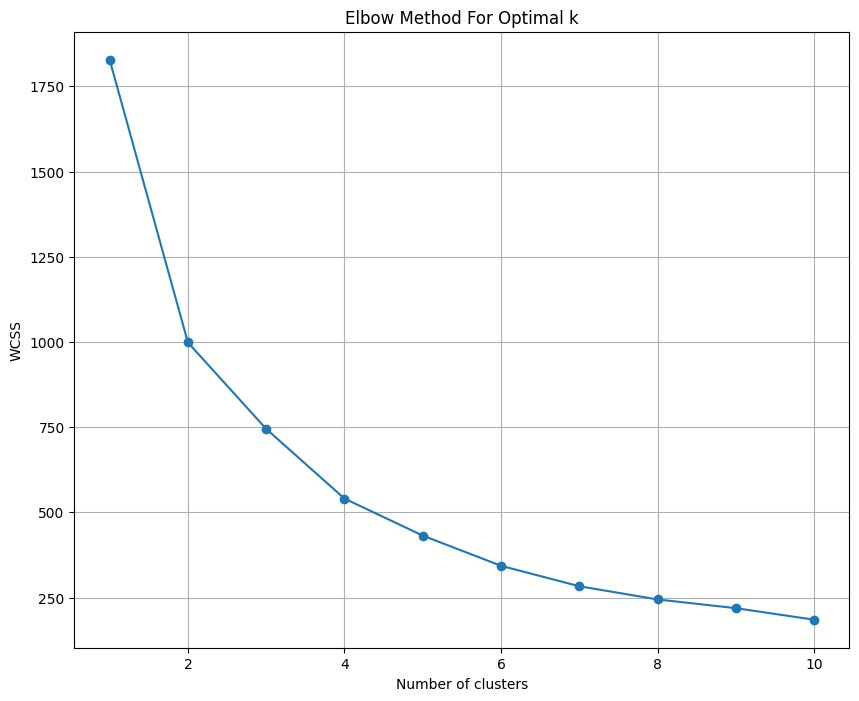

In [39]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


def load_and_preprocess_data(yearly_kline_file):
    """读取数据并进行预处理"""
    df = pd.read_excel(yearly_kline_file)
    features = df[['涨跌幅(%)', '振幅(%)']]
    # 数据标准化
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(features)
    return data_scaled, df

def plot_elbow_curve(data_scaled):
    """绘制肘部法则曲线"""
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data_scaled)
        wcss.append(kmeans.inertia_)
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid()
    plt.show()

yearly_kline = 'kline_data/yearly_kline_data.xlsx'
data_scaled, data_frame = load_and_preprocess_data(yearly_kline)
plot_elbow_curve(data_scaled)


#### 2.2. 创建并可视化 KMeans 聚类模型

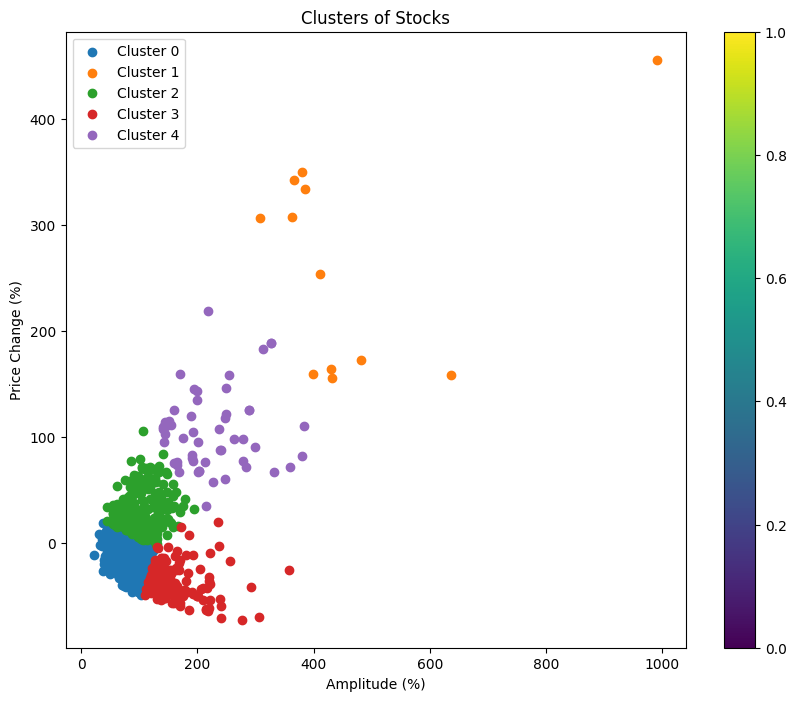

Cluster                0           1           2           3           4
涨跌幅(%) count  432.000000   12.000000  244.000000  172.000000   54.000000
       mean   -16.588889  263.640542   30.213613  -37.110017  105.659343
       std     15.081409  100.456178   18.935978   15.414204   37.091179
       min    -49.004975  156.164384   -1.154891  -72.135103   35.111663
       25%    -28.552983  163.482171   16.547310  -46.191500   76.654539
       50%    -17.775472  280.428636   25.710425  -40.435951  101.416664
       75%     -4.107447  336.254357   40.727539  -27.342012  121.724610
       max     19.554455  456.140351  105.680317   20.097245  218.930041
振幅(%)  count  432.000000   12.000000  244.000000  172.000000   54.000000
       mean    80.406827  465.066489  101.816305  157.377669  223.302350
       std     21.407738  185.002553   29.713714   39.922829   65.582624
       min     21.458863  307.167235   43.871866  108.955224  140.114943
       25%     65.226390  376.773354   80.138100  1

In [43]:
def create_and_visualize_kmeans_model(data_scaled, df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    df['Cluster'] = kmeans.fit_predict(data_scaled)
    
    # 聚类可视化
    plt.figure(figsize=(10, 8))
    for i in range(n_clusters):
        cluster = df[df['Cluster'] == i]
        plt.scatter(cluster['振幅(%)'], cluster['涨跌幅(%)'], label=f'Cluster {i}')
    plt.colorbar()
    
    plt.title('Clusters of Stocks')
    plt.xlabel('Amplitude (%)')
    plt.ylabel('Price Change (%)')
    plt.legend()
    plt.show()

    # 分析每个簇的特性
    print(df.groupby('Cluster')[['涨跌幅(%)', '振幅(%)']].describe().T)

n_clusters = 5
create_and_visualize_kmeans_model(data_scaled, data_frame, n_clusters)

#### 2.3. 对每个簇进行分析

- 簇0：这个簇的涨跌幅比较小，振幅也较小，这些股票可能是相对保守的股票，整体表现较为稳定，适合风险承受能力较低的投资者。

- 簇1：这个簇的股票表现非常活跃，涨幅巨大，振幅也很大，可能是市场上非常受欢迎的热门股票，适合寻求高回报且能够承受高风险的投资者。但是这个簇只包含12个样本，可能反映了一些极端行情的股票，投资者需要谨慎参考。

- 簇2：这个簇的涨跌幅较大，振幅也比较大，这些股票可能是行情较好的热门股。这些股票在市场上表现良好，适合希望在相对稳定的市场中获取较高收益的投资者。

- 簇3：这个簇的涨跌幅、振幅很小，这些股票可能是相对稳定的股票。这些股票表现较为保守，适合希望投资于稳定市场、并与其他高收益股票配合的投资者。

- 簇4：这个簇的涨跌幅、振幅较大，这些股票可能是市场上的热门股票，风险较大，但是收益也较高。

### 3. 行业数据可视化分析